In [1]:
import requests
import torch

from diffusers import (
    DiffusionPipeline, 
    StableDiffusionPipeline, 
    StableDiffusionXLPipeline, 
    UNet2DConditionModel, 
    EulerDiscreteScheduler,
    LCMScheduler, 
    AutoPipelineForText2Image
)
from huggingface_hub import hf_hub_download
from PIL import Image, ImageDraw
from safetensors.torch import load_file
from transformers import pipeline, DetrImageProcessor, DetrForObjectDetection

/Users/nickdinapoli/github/pytorch-playground/.conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

device

device(type='mps')

## Text-to-Image

In [ ]:
pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16,
    use_safetensors=True,
)

prompt = "An astronaut riding a green horse"

# pipe.enable_attention_slicing()
image = pipe(prompt=prompt).images[0]
image

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
pipe = DiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float32, use_safetensors=True)
pipe.to("cpu")

prompt = "An astronaut riding a green horse"

image = pipe(prompt=prompt).images[0]
image

/Users/nickdinapoli/github/pytorch-playground/.conda/lib/python3.11/site-packages/diffusers/configuration_utils.py:245: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a model, please use <class 'diffusers.models.unets.unet_2d_condition.UNet2DConditionModel'>.load_config(...) followed by <class 'diffusers.models.unets.unet_2d_condition.UNet2DConditionModel'>.from_config(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  deprecate("config-passed-as-path", "1.0.0", deprecation_message, standard_warn=False)
100%|██████████| 4/4 [03:01<00:00, 45.26s/it]


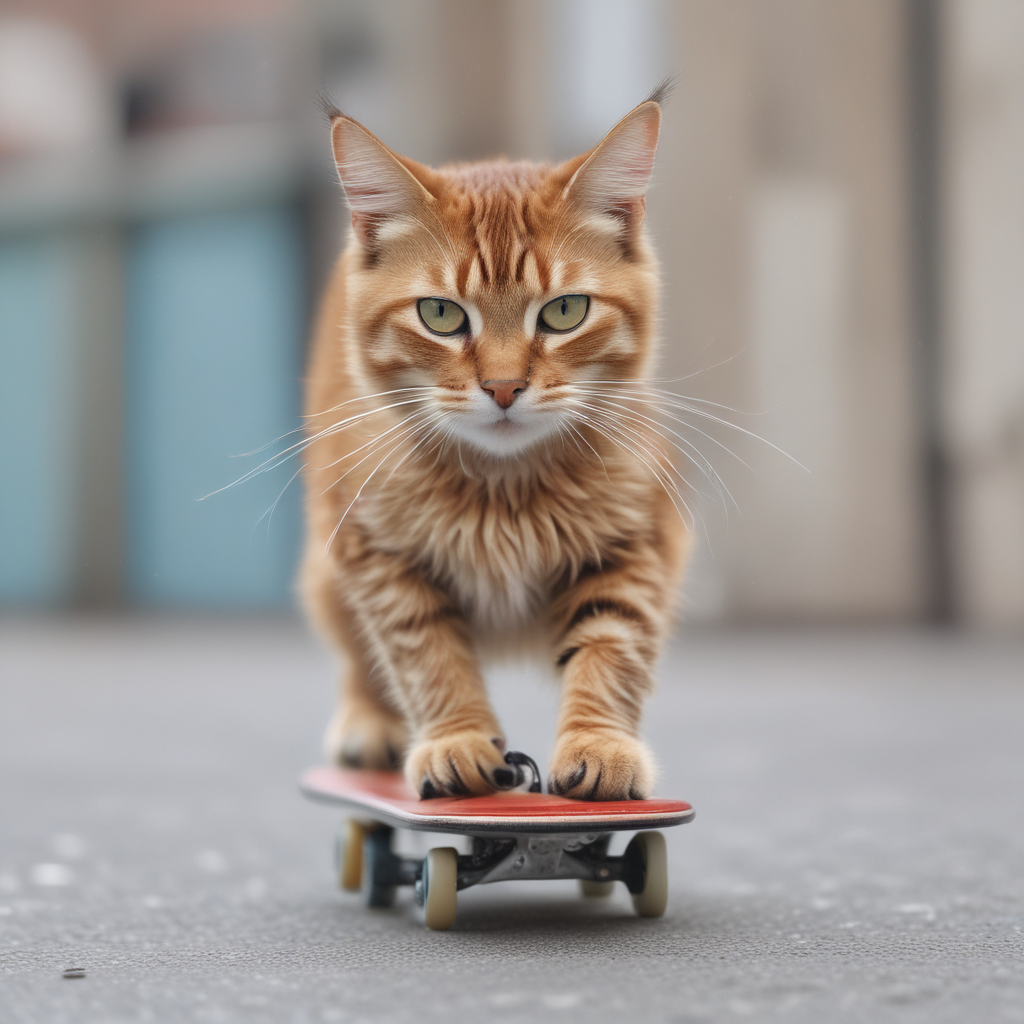

In [ ]:
base = "stabilityai/stable-diffusion-xl-base-1.0"
repo = "ByteDance/SDXL-Lightning"
ckpt = "sdxl_lightning_4step_unet.safetensors"

# Load model and move to CPU with single precision
unet = UNet2DConditionModel.from_config(base, subfolder="unet").to("cpu")
unet.load_state_dict(load_file(hf_hub_download(repo, ckpt), device="cpu"))

# Initialize pipeline with CPU and single precision
pipe = StableDiffusionXLPipeline.from_pretrained(base, unet=unet, torch_dtype=torch.float32).to("cpu")

# Ensure sampler uses "trailing" timesteps
pipe.scheduler = EulerDiscreteScheduler.from_config(pipe.scheduler.config, timestep_spacing="trailing")

# Generate image with specified inference steps and CFG scale
result = pipe("A cat skating", num_inference_steps=4, guidance_scale=0)
image = result.images[0]
image

In [10]:
image.size

(1024, 1024)

In [ ]:
pipeline = DiffusionPipeline.from_pretrained("digiplay/AbsoluteReality_v1.8.1").to(device)

prompt = "An astronaut riding a green horse"

images = pipeline(prompt=prompt).images[0]
images

In [ ]:
model_id = "Lykon/dreamshaper-7"
adapter_id = "latent-consistency/lcm-lora-sdv1-5"

# Initialize the pipeline with single precision
pipe = AutoPipelineForText2Image.from_pretrained(model_id, torch_dtype=torch.float32)
pipe.scheduler = LCMScheduler.from_config(pipe.scheduler.config)
pipe.to("cpu")

# Load and fuse lcm lora
pipe.load_lora_weights(adapter_id)
pipe.fuse_lora()

prompt = "An astronaut riding a green horse"

# Disable guidance_scale by passing 0
images = pipe(prompt=prompt, num_inference_steps=4, guidance_scale=0)
image = images.images[0]

## Object Detection

No model was supplied, defaulted to facebook/detr-resnet-50 and revision 1d5f47b (https://huggingface.co/facebook/detr-resnet-50).
Using a pipeline without specifying a model name and revision in production is not recommended.
Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a 

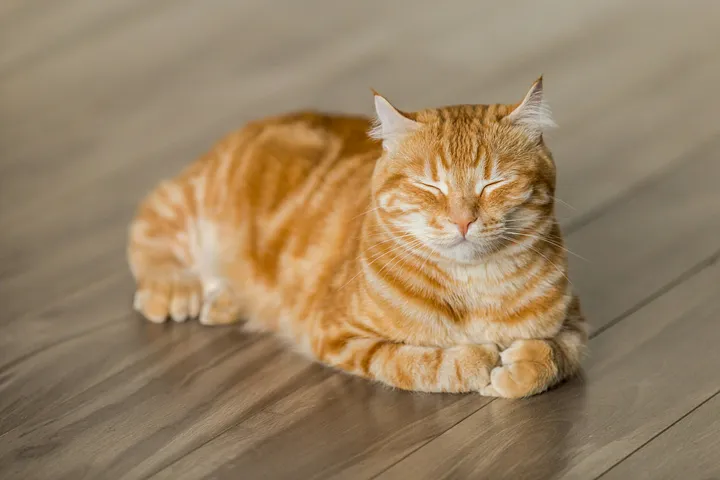

[{'score': 0.9034131169319153,
  'label': 'cat',
  'box': {'xmin': 125, 'ymin': 72, 'xmax': 593, 'ymax': 404}},
 {'score': 0.897133469581604,
  'label': 'cat',
  'box': {'xmin': 281, 'ymin': 72, 'xmax': 594, 'ymax': 404}}]

In [14]:
model = pipeline("object-detection")
result = model("data/cat.jpg")

test_image = Image.open("data/cat.jpg")
display(test_image)

result

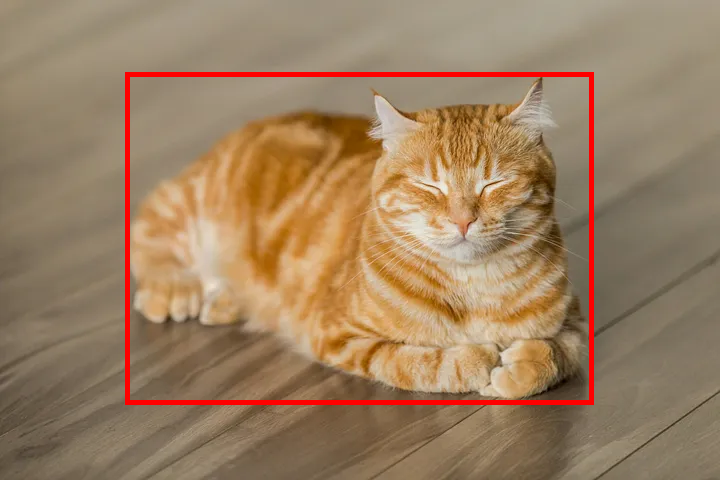

In [15]:
box = result[0]["box"]
draw = ImageDraw.Draw(test_image)
bounding_box = (box['xmin'], box['ymin'], box['xmax'], box['ymax'])
draw.rectangle(bounding_box, outline="red", width=5)

display(test_image)

In [24]:
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
test_image2 = Image.open(requests.get(url, stream=True).raw)

processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50", revision="no_timm")
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50", revision="no_timm")

inputs = processor(images=test_image2, return_tensors="pt")
outputs = model(**inputs)

# Convert outputs (bounding boxes and class logits) to COCO API
# Only keep detections with score > 0.9
target_sizes = torch.tensor([test_image2.size[::-1]])
results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.9)[0]

detected_objects = []
for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    detected_objects.append({"label": model.config.id2label[label.item()],
                             "score": round(score.item(), 3),
                             "box": box})

    print(f"Detected {model.config.id2label[label.item()]} with confidence {round(score.item(), 3)} at location {box}")

Detected remote with confidence 0.998 at location [40.16, 70.81, 175.55, 117.98]
Detected remote with confidence 0.996 at location [333.24, 72.55, 368.33, 187.66]
Detected couch with confidence 0.995 at location [-0.02, 1.15, 639.73, 473.76]
Detected cat with confidence 0.999 at location [13.24, 52.05, 314.02, 470.93]
Detected cat with confidence 0.999 at location [345.4, 23.85, 640.37, 368.72]


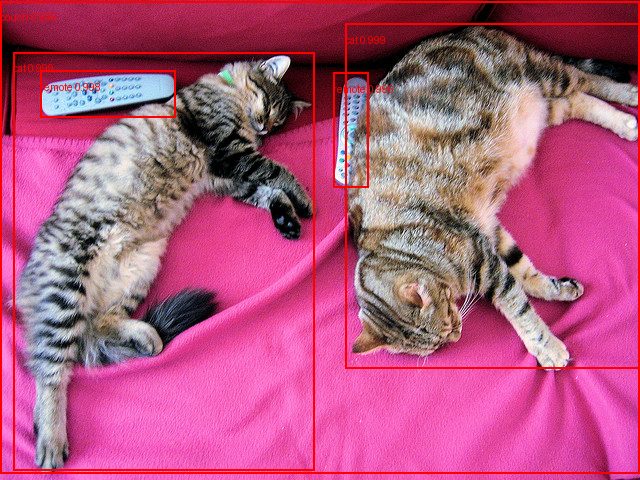

In [25]:
draw = ImageDraw.Draw(test_image2)

for obj in detected_objects:
    box = obj['box']
    label = obj['label']
    score = obj['score']

    draw.rectangle(box, outline="red", width=2)

    text = f"{label} {score:.3f}"
    draw.text((box[0], box[1] + 10), text, fill="red")

display(test_image2)

## Image-to-text